In [1]:
"""We define the class for simulating the Rock-Paper-Scissors-Lizard-Spock model."""

import torch
import matplotlib.pyplot as plt
import math
import spectre.model
import spectre.spectrum_general
from spectre.spectrum_general import matrix_solution
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import element_wise
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import recursive_solution
from spectre.model import RPS
import os
import numpy as np

os.chdir("..")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

fileloc = r"figures/RPS/"

In [2]:
"""Define the colors for the different methods"""

color_recursive = "#FFA353"
color_elementwise = "#095400"
color_matrix = "#1B3B9D"
color_sim = "k"

linewidth_recursive = 12
linewidth_elementwise = 3.5
marker_matrix = 8
simulation_marker = 12

font_size = 28

In [3]:
"""Define the RPS system"""

n = 5  # number of strategies
eta = 0.01  # S.D. of the noise
model = RPS(n, eta=eta, noise_type="multiplicative")  # create the RPS object
model.mu = 0.01

In [4]:
"""Define the simulation parameters"""

ndivs = 15
n_points = int(2e6)
time = 25000
# time = 25
dt = 0.5e-1

In [5]:
"""Define the frequency vectors"""

min_freq = 1e-3
max_freq = 10
n_freq_mat = 60
n_freq_rat = 1000

"""Define the frequency vectors for the matrix and rational solutions"""
freq_mat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_mat)
freq_rat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_rat)

In [6]:
"""Find auto-spectra using different schemes"""

idx = 1  # index of the population we are interested in (Paper population)

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
psd_matrix, _ = mat_model.auto_spectrum(idx, freq_mat)

"""Analytical solution (elementwise)"""
rat_model = element_wise(model.J, model.L, model.S)
psd_rational, _ = rat_model.auto_spectrum(idx, freq_rat)

"""Analytical solution (recursive algorithm)"""
recursive_model = recursive_solution(model.J, model.L, model.S)
psd_recursive, _ = recursive_model.auto_spectrum(idx, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
psd_sim, f = sim_model.simulation_spectrum(
    i=idx, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

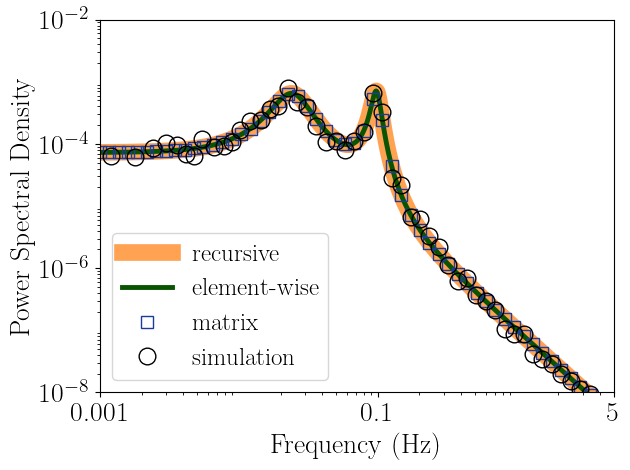

In [26]:
plt.figure(1)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.loglog(
    freq_rat,
    psd_recursive,
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
plt.loglog(
    freq_rat,
    psd_rational,
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
plt.loglog(
    freq_mat,
    psd_matrix,
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
plt.loglog(
    f[idx_closest],
    psd_sim[idx_closest],
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
plt.legend(fontsize=18, loc="lower left")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Power Spectral Density", fontsize=20)
plt.xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"], fontsize=20)
plt.yticks([1e-8, 1e-6, 1e-4, 1e-2], fontsize=20)
plt.xlim([1e-3, 5])
plt.ylim([1e-8, 1e-2])
plt.tight_layout()
plt.savefig(fileloc + "psd_rps.svg", format="svg", dpi=1200)
plt.show()

In [8]:
"""Plot the cross-spectrum between Rock and Paper populations"""

i = 0
j = 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
cpsd_matrix, _ = mat_model.cross_spectrum(i, j, freq_mat)

"""Analytical solution (elementwise)"""
rat_model = element_wise(model.J, model.L, model.S)
cpsd_rational, _ = rat_model.cross_spectrum(i, j, freq_rat)

"""Analytical solution (recursive algorithm)"""
recursive_model = recursive_solution(model.J, model.L, model.S)
cpsd_recursive, _ = recursive_model.cross_spectrum(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
cpsd_sim, f = sim_model.simulation_spectrum(
    i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

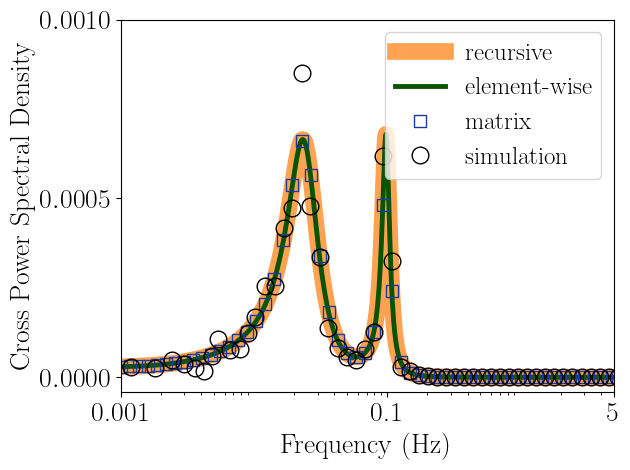

In [9]:
plt.figure(2)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(
    freq_rat,
    torch.abs(cpsd_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
plt.semilogx(
    freq_rat,
    torch.abs(cpsd_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
plt.semilogx(
    freq_mat,
    torch.abs(cpsd_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
plt.semilogx(
    f[idx_closest],
    torch.abs(cpsd_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
plt.legend(fontsize=18, loc="upper right")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Cross Power Spectral Density", fontsize=20)
plt.xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"], fontsize=20)
plt.yticks([0, 0.0005, 0.001], fontsize=20)
plt.xlim([1e-3, 5])
# plt.ylim([1e-8, 1e-1])
plt.tight_layout()
plt.savefig(fileloc + "cpsd_rps_absolute.svg", format="svg", dpi=1200)
plt.show()

In [10]:
"""Plot the coherence between Rock and Paper populations"""

i = 0
j = 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
coh_matrix, _ = mat_model.coherence(i=i, j=j, freq=freq_mat)

"""Analytical solution (elementwise)"""
rat_model = element_wise(model.J, model.L, model.S)
coh_rational, _ = rat_model.coherence(i, j, freq_rat)

"""Analytical solution (recursive algorithm)"""
recursive_model = recursive_solution(model.J, model.L, model.S)
coh_recursive, _ = recursive_model.coherence(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
coh_sim, f = sim_model.simulation_coherence(
    i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

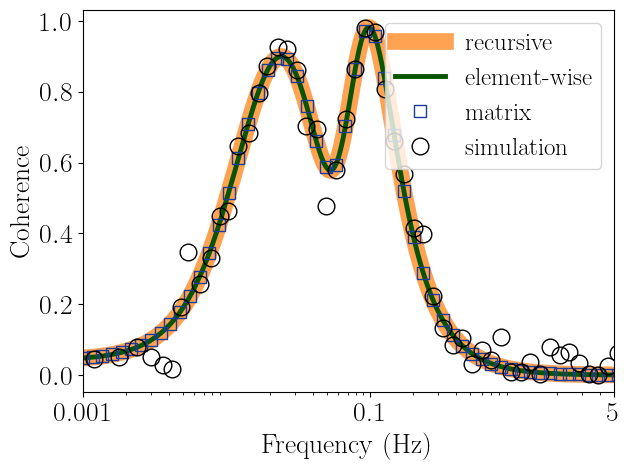

In [11]:
plt.figure(3)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(
    freq_rat,
    torch.abs(coh_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
plt.semilogx(
    freq_rat,
    torch.abs(coh_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
plt.semilogx(
    freq_mat,
    torch.abs(coh_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
plt.semilogx(
    f[idx_closest],
    torch.abs(coh_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
plt.legend(fontsize=18, loc="upper right")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Coherence", fontsize=20)
plt.xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"], fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
plt.xlim([1e-3, 5])
# plt.ylim([0, 1])
plt.tight_layout()
plt.savefig(fileloc + "coh_rps.svg", format="svg", dpi=1200)
plt.show()

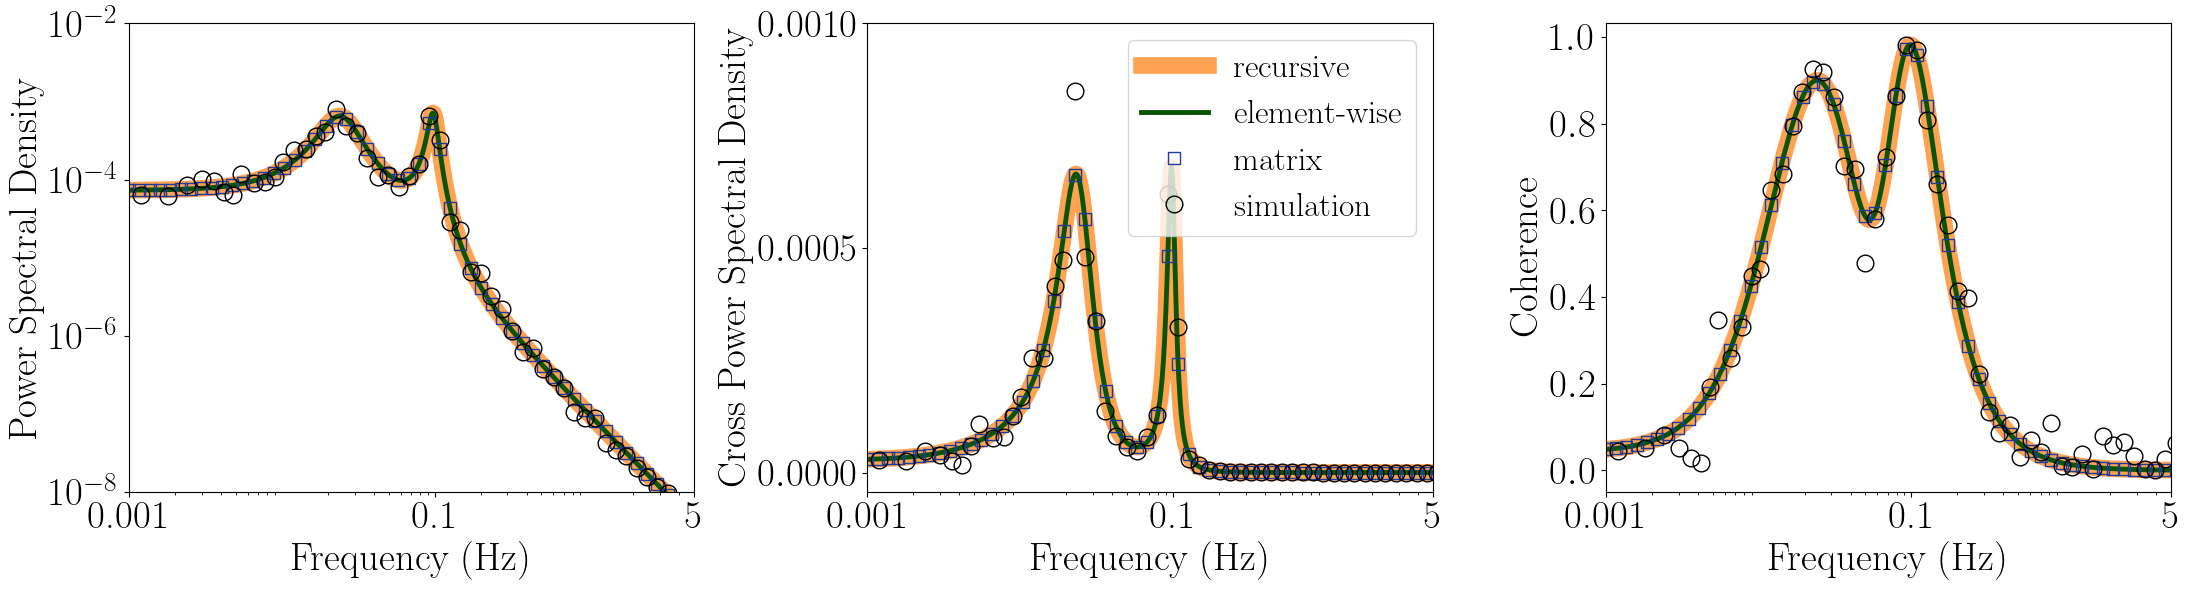

In [27]:
"""Combined figure"""

fig, ax = plt.subplots(1, 3, figsize=(22, 6))

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[0].loglog(
    freq_rat,
    psd_recursive,
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
ax[0].loglog(
    freq_rat,
    psd_rational,
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
ax[0].loglog(
    freq_mat,
    psd_matrix,
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
ax[0].loglog(
    f[idx_closest],
    psd_sim[idx_closest],
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
# ax[0].legend(fontsize=18, loc='lower left')
ax[0].set_xlabel("Frequency (Hz)", fontsize=font_size)
ax[0].set_ylabel("Power Spectral Density", fontsize=font_size)
ax[0].set_xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"])
ax[0].set_yticks([1e-8, 1e-6, 1e-4, 1e-2])
ax[0].tick_params(axis="x", labelsize=font_size)
ax[0].tick_params(axis="y", labelsize=font_size)
ax[0].set_xlim([1e-3, 5])
ax[0].set_ylim([1e-8, 1e-2])

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[1].semilogx(
    freq_rat,
    torch.abs(cpsd_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
ax[1].semilogx(
    freq_rat,
    torch.abs(cpsd_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
ax[1].semilogx(
    freq_mat,
    torch.abs(cpsd_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
ax[1].semilogx(
    f[idx_closest],
    torch.abs(cpsd_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
ax[1].legend(fontsize=24, loc="upper right")
ax[1].set_xlabel("Frequency (Hz)", fontsize=font_size)
ax[1].set_ylabel("Cross Power Spectral Density", fontsize=font_size)
ax[1].set_xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"])
ax[1].set_yticks([0, 0.0005, 0.001])
ax[1].tick_params(axis="x", labelsize=font_size)
ax[1].tick_params(axis="y", labelsize=font_size)
# set ytick fontsize larger
ax[1].set_xlim([1e-3, 5])
# ax[1].set_ylim([1e-8, 1e-1])


idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[2].semilogx(
    freq_rat,
    torch.abs(coh_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
ax[2].semilogx(
    freq_rat,
    torch.abs(coh_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
ax[2].semilogx(
    freq_mat,
    torch.abs(coh_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
ax[2].semilogx(
    f[idx_closest],
    torch.abs(coh_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
# ax[2].legend(fontsize=18, loc='upper right')
ax[2].set_xlabel("Frequency (Hz)", fontsize=font_size)
ax[2].set_ylabel("Coherence", fontsize=font_size)
ax[2].set_xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"])
ax[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[2].tick_params(axis="x", labelsize=font_size)
ax[2].tick_params(axis="y", labelsize=font_size)
ax[2].set_xlim([1e-3, 5])
# ax[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(fileloc + "combined_RPS.svg", format="svg", dpi=1200)
plt.show()

In [13]:
"""Define the mutation parameter (mu) tensor"""

pts = 1000
mu_min = 0.001
mu_max = 1
mu0 = torch.logspace(start=math.log10(mu_min), end=math.log10(mu_max), steps=pts)
inv_idx = torch.arange(mu0.size(0) - 1, -1, -1).long()
inv_tensor = mu0.index_select(0, inv_idx)
mu = mu0[inv_idx]

In [14]:
"""Coefficients of the numerator and denominator"""

dim = model.dim
p = torch.empty(dim, pts)
q = torch.empty(dim + 1, pts)

"""Make The Coefficient of omega in Numerator and Denominator plots"""
for i in range(pts):
    model.mu = mu[i]
    model.jacobian()
    rat_model = element_wise(model.J, model.L, model.S)
    p[:, i] = torch.Tensor(rat_model.p_auto_all_coeffs(idx))
    q[:, i] = torch.Tensor(rat_model.q_all_coeffs())

In [15]:
"""Make the mu vector for which the spectrum has to be calculated"""

mu_spect = torch.tensor([mu_min, mu_max])
for i in range(dim):
    id = torch.where(p[i, :] < 0)[0]
    if id.size(0) > 0:
        mu_spect = torch.cat((mu_spect, mu[id[0]].flatten()))

for i in range(dim + 1):
    id = torch.where(q[i, :] < 0)[0]
    if id.size(0) > 0:
        mu_spect = torch.cat((mu_spect, mu[id[0]].flatten()))

mu_spect = torch.sort(mu_spect.unique())[0]

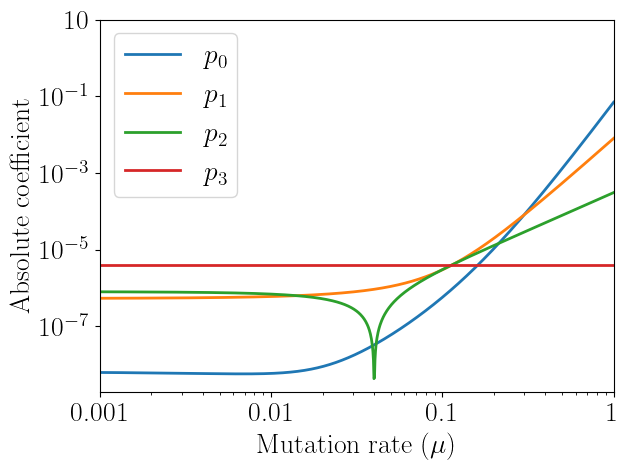

In [16]:
"""Plot the Absolute Value of the Coefficients of omega in Numerator"""

plt.figure(4)
plt.clf()
for i in range(dim):
    plt.plot(mu, torch.abs(p[i, :]), label=r"$p_{}$".format(i), linewidth=2)
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20, loc="upper left")
plt.xlabel("Mutation rate ($\mu$)", fontsize=20)
plt.ylabel("Absolute coefficient", fontsize=20)
plt.xticks([1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=20)
plt.yticks(
    [1e-7, 1e-5, 1e-3, 1e-1, 1e1],
    ["$10^{-7}$", "$10^{-5}$", "$10^{-3}$", "$10^{-1}$", "$10$"],
    fontsize=20,
)
plt.xlim([1e-3, 1])
# plt.ylim([1e-10, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + "p_abs_coeffs.svg", format="svg", dpi=1200)
plt.show()

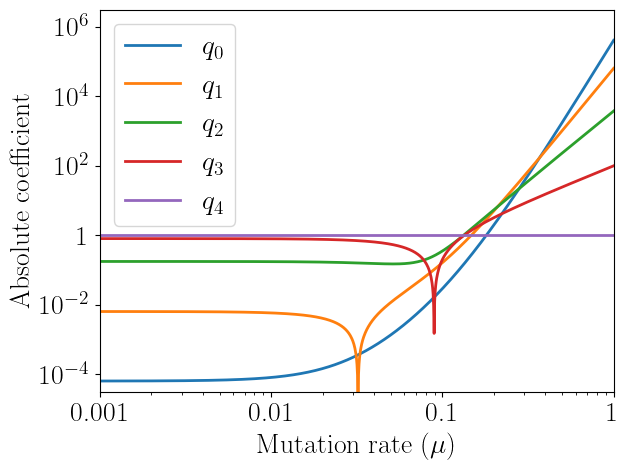

In [17]:
"""Plot the Absolute Value of the Coefficients of omega in Denominator"""

plt.figure(5)
plt.clf()
for i in range(dim + 1):
    plt.loglog(mu, torch.abs(q[i, :]), label=r"$q_{}$".format(i), linewidth=2)
plt.legend(fontsize=20, loc="upper left")
plt.xlabel("Mutation rate ($\mu$)", fontsize=20)
plt.ylabel("Absolute coefficient", fontsize=20)
plt.xticks([1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=20)
plt.yticks(
    [1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6],
    ["$10^{-4}$", "$10^{-2}$", "$1$", "$10^2$", "$10^4$", "$10^6$"],
    fontsize=20,
)
plt.xlim([1e-3, 1])
plt.ylim([3e-5, 3e6])
plt.tight_layout()
plt.savefig(fileloc + "q_coeffs.svg", format="svg", dpi=1200)
plt.show()

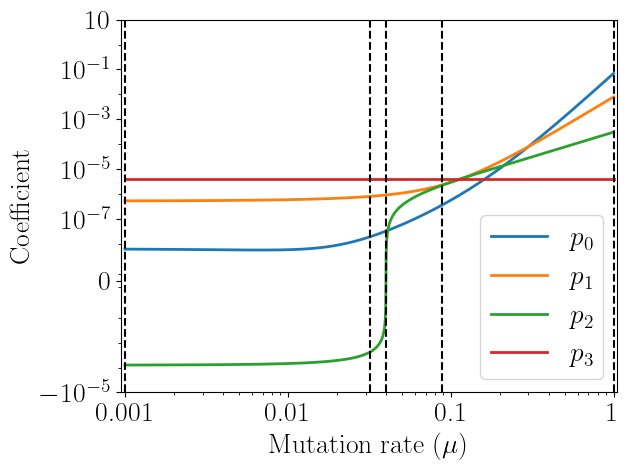

In [18]:
"""Plot the Coefficients of omega in Numerator"""

plt.figure(6)
plt.clf()
for i in range(dim):
    plt.plot(mu, p[i, :], label=r"$p_{}$".format(i), linewidth=2)
threshold = torch.min(torch.abs(p)).item()
plt.yscale("symlog", linthresh=threshold)
plt.xscale("log")
for i in range(mu_spect.size(0)):
    plt.axvline(mu_spect[i], color="k", linestyle="--")
plt.legend(fontsize=20, loc="lower right")
plt.xlabel("Mutation rate ($\mu$)", fontsize=20)
plt.ylabel("Coefficient", fontsize=20)
plt.xticks([1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=20)
plt.yticks(
    [-1e-5, 0, 1e-7, 1e-5, 1e-3, 1e-1, 1e1],
    ["$-10^{-5}$", "0", "$10^{-7}$", "$10^{-5}$", "$10^{-3}$", "$10^{-1}$", "$10$"],
    fontsize=20,
)
plt.xlim([0.95e-3, 1.05])
# plt.ylim([1e-10, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + "p_coeffs.svg", format="svg", dpi=1200)
plt.show()

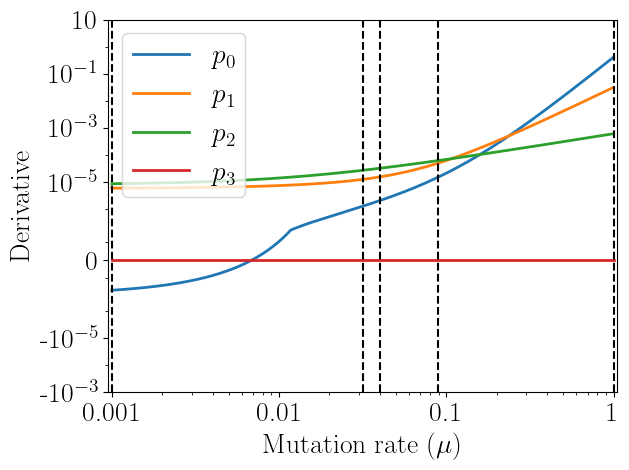

In [19]:
"""Plot the derivative of the Coefficients of omega in Numerator"""

# Using central difference method, the derivative is
dp = torch.empty(dim, pts)
for i in range(dim):
    dp[i, 1:-1] = (p[i, 2:] - p[i, :-2]) / (mu[2:] - mu[:-2])
    dp[i, 0] = (p[i, 1] - p[i, 0]) / (mu[1] - mu[0])
    dp[i, -1] = (p[i, -1] - p[i, -2]) / (mu[-1] - mu[-2])

plt.figure(7)
plt.clf()
for i in range(dim):
    plt.plot(mu, dp[i, :], label=r"$p_{}$".format(i), linewidth=2)
threshold = torch.abs(torch.min(dp)).item()
plt.yscale("symlog", linthresh=threshold)
plt.xscale("log")
for i in range(mu_spect.size(0)):
    plt.axvline(mu_spect[i], color="k", linestyle="--")
plt.legend(fontsize=20, loc="upper left")
plt.xlabel("Mutation rate ($\mu$)", fontsize=20)
plt.ylabel("Derivative", fontsize=20)
plt.xticks([1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=20)
plt.yticks(
    [-1e-3, -1e-5, 0, 1e-5, 1e-3, 1e-1, 10],
    ["-$10^{-3}$", "-$10^{-5}$", "0", "$10^{-5}$", "$10^{-3}$", "$10^{-1}$", "$10$"],
    fontsize=20,
)
plt.xlim([0.95e-3, 1.05])
# plt.ylim([1e-10, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + "p_coeffs_deriv.svg", format="svg", dpi=1200)
plt.show()

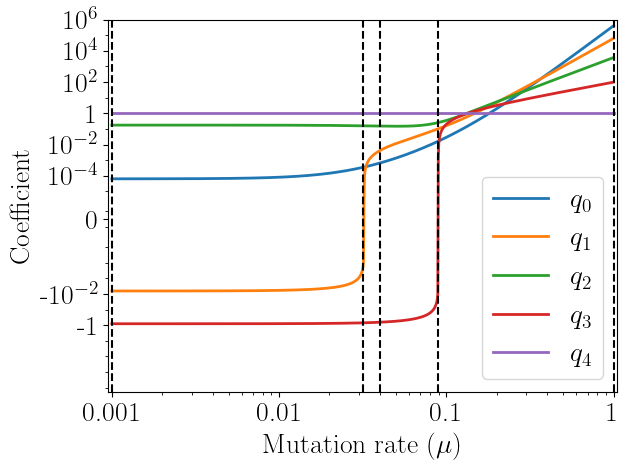

In [20]:
"""Plot the Coefficients of omega in Denominator"""

plt.figure(8)
plt.clf()
for i in range(dim + 1):
    plt.plot(mu, q[i, :], label=r"$q_{}$".format(i), linewidth=2)
for i in range(mu_spect.size(0)):
    plt.axvline(mu_spect[i], color="k", linestyle="--")
threshold = torch.min(torch.abs(q)).item()
plt.yscale("symlog", linthresh=threshold)
plt.xscale("log")
plt.legend(fontsize=20, loc="lower right")
plt.xlabel("Mutation rate ($\mu$)", fontsize=20)
plt.ylabel("Coefficient", fontsize=20)
plt.xticks([1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=20)
plt.yticks(
    [-1, -1e-2, 0, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6],
    [
        "-1",
        "-$10^{-2}$",
        "0",
        "$10^{-4}$",
        "$10^{-2}$",
        "$1$",
        "$10^2$",
        "$10^4$",
        "$10^6$",
    ],
    fontsize=20,
)
plt.xlim([0.95e-3, 1.05])
# plt.ylim([1e-10, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + "q_coeffs.svg", format="svg", dpi=1200)
plt.show()

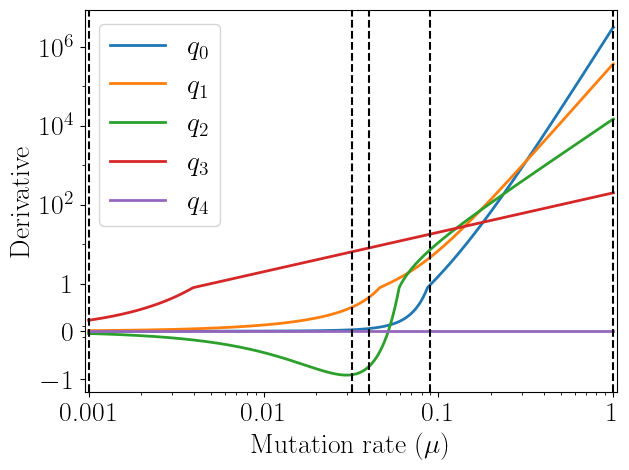

In [21]:
"""Plot the derivative of the Coefficients of omega in Denominator"""

# Using central difference method, the derivative is
dq = torch.empty(dim + 1, pts)
for i in range(dim + 1):
    dq[i, 1:-1] = (q[i, 2:] - q[i, :-2]) / (mu[2:] - mu[:-2])
    dq[i, 0] = (q[i, 1] - q[i, 0]) / (mu[1] - mu[0])
    dq[i, -1] = (q[i, -1] - q[i, -2]) / (mu[-1] - mu[-2])

plt.figure(9)
plt.clf()
for i in range(dim + 1):
    plt.plot(mu, dq[i, :], label=r"$q_{}$".format(i), linewidth=2)
threshold = torch.abs(torch.min(dq)).item()
plt.yscale("symlog", linthresh=threshold)
plt.xscale("log")
for i in range(mu_spect.size(0)):
    plt.axvline(mu_spect[i], color="k", linestyle="--")
plt.legend(fontsize=20, loc="upper left")
plt.xlabel("Mutation rate ($\mu$)", fontsize=20)
plt.ylabel("Derivative", fontsize=20)
plt.xticks([1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=20)
plt.yticks(
    [-1, 0, 1, 1e2, 1e4, 1e6],
    ["$-1$", "$0$", "$1$", "$10^{2}$", "$10^{4}$", "$10^{6}$"],
    fontsize=20,
)
plt.xlim([0.95e-3, 1.05])
# plt.ylim([1e-10, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + "q_coeffs_deriv.svg", format="svg", dpi=1200)
plt.show()

In [22]:
"""Find the Power Spectral Density for of each of the mu_spect"""

freq = torch.logspace(start=math.log10(0.001), end=math.log10(10), steps=1000)
psd_mu = torch.empty(freq.size(0), mu_spect.size(0))
for i in range(mu_spect.size(0)):
    model.mu = mu_spect[i]
    model.jacobian()
    rat_model = element_wise(model.J, model.L, model.S)
    psd_mu[:, i], _ = rat_model.auto_spectrum(idx, freq)

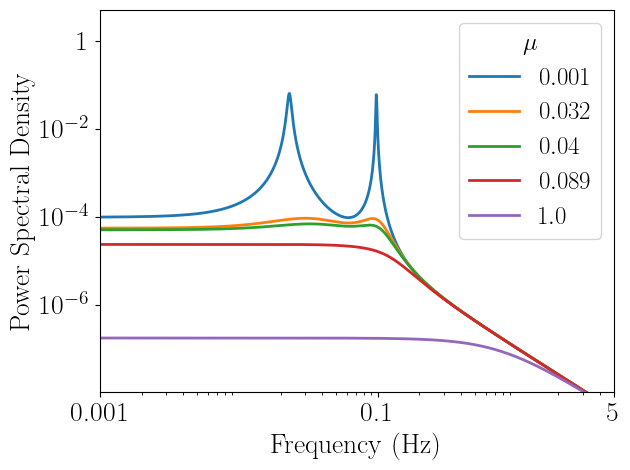

In [23]:
"""Plot the analytical power spectrum for different mu"""

plt.figure(10)
plt.clf()
for i in range(mu_spect.size(0)):
    plt.loglog(
        freq,
        psd_mu[:, i],
        label=r"${}$".format(torch.round(mu_spect[i], decimals=3)),
        linewidth=2,
    )
plt.legend(fontsize=18, loc="upper right", title=r"$\mu$", title_fontsize=18)
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Power Spectral Density", fontsize=20)
plt.xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"], fontsize=20)
plt.yticks(
    [1e-6, 1e-4, 1e-2, 1e0], ["$10^{-6}$", "$10^{-4}$", "$10^{-2}$", "$1$"], fontsize=20
)
plt.xlim([1e-3, 5])
plt.ylim([1e-8, 5])
plt.tight_layout()
plt.savefig(fileloc + "psd_for_diff_mu.svg", format="svg", dpi=1200)
plt.show()

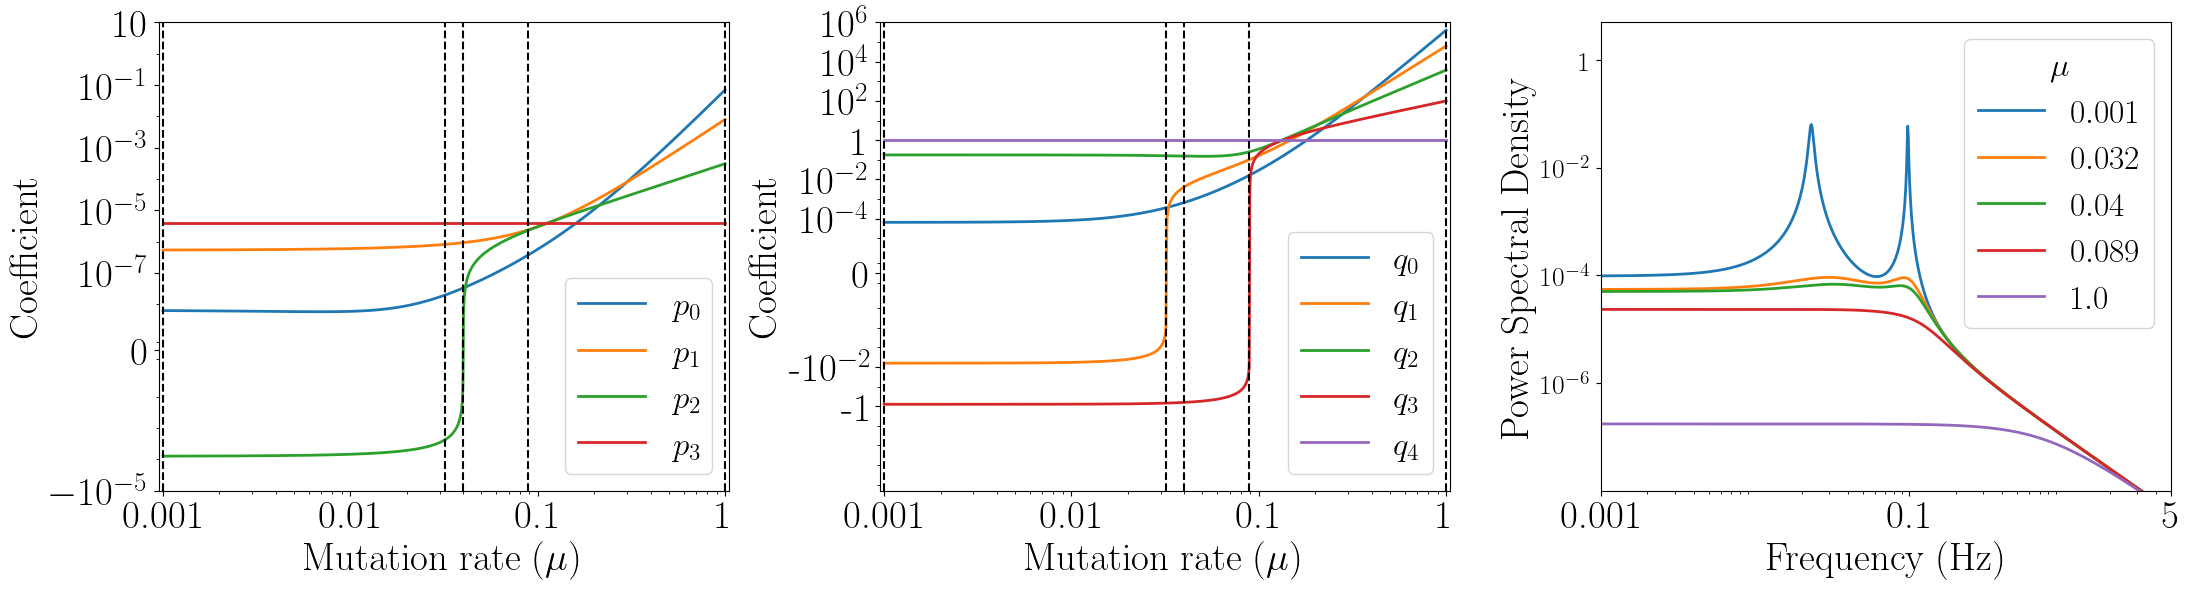

In [24]:
"""Combined figures"""

fig, ax = plt.subplots(1, 3, figsize=(22, 6))

for i in range(dim):
    ax[0].plot(mu, p[i, :], label=r"$p_{}$".format(i), linewidth=2)
threshold = torch.min(torch.abs(p)).item()
ax[0].set_yscale("symlog", linthresh=threshold)
ax[0].set_xscale("log")
for i in range(mu_spect.size(0)):
    ax[0].axvline(mu_spect[i], color="k", linestyle="--")
ax[0].legend(fontsize=24, loc="lower right")
ax[0].set_xlabel("Mutation rate ($\mu$)", fontsize=font_size)
ax[0].set_ylabel("Coefficient", fontsize=font_size)
ax[0].set_xticks(
    [1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=font_size
)
ax[0].set_yticks(
    [-1e-5, 0, 1e-7, 1e-5, 1e-3, 1e-1, 1e1],
    ["$-10^{-5}$", "0", "$10^{-7}$", "$10^{-5}$", "$10^{-3}$", "$10^{-1}$", "$10$"],
    fontsize=font_size,
)
ax[0].set_xlim([0.95e-3, 1.05])
# ax[0].set_ylim([1e-10, 1e-5])


for i in range(dim + 1):
    ax[1].plot(mu, q[i, :], label=r"$q_{}$".format(i), linewidth=2)
for i in range(mu_spect.size(0)):
    ax[1].axvline(mu_spect[i], color="k", linestyle="--")
threshold = torch.min(torch.abs(q)).item()
ax[1].set_yscale("symlog", linthresh=threshold)
ax[1].set_xscale("log")
ax[1].legend(fontsize=24, loc="lower right")
ax[1].set_xlabel("Mutation rate ($\mu$)", fontsize=font_size)
ax[1].set_ylabel("Coefficient", fontsize=font_size)
ax[1].set_xticks(
    [1e-3, 1e-2, 1e-1, 1], ["0.001", "0.01", "0.1", "1"], fontsize=font_size
)
ax[1].set_yticks(
    [-1, -1e-2, 0, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6],
    [
        "-1",
        "-$10^{-2}$",
        "0",
        "$10^{-4}$",
        "$10^{-2}$",
        "$1$",
        "$10^2$",
        "$10^4$",
        "$10^6$",
    ],
    fontsize=font_size,
)
ax[1].set_xlim([0.95e-3, 1.05])
# ax[1].set_ylim([1e-10, 1e-5])


for i in range(mu_spect.size(0)):
    ax[2].loglog(
        freq,
        psd_mu[:, i],
        label=r"${}$".format(torch.round(mu_spect[i], decimals=3)),
        linewidth=2,
    )
ax[2].legend(fontsize=24, loc="upper right", title=r"$\mu$", title_fontsize=24)
ax[2].set_xlabel("Frequency (Hz)", fontsize=font_size)
ax[2].set_ylabel("Power Spectral Density", fontsize=font_size)
ax[2].set_xticks([1e-3, 1e-1, 5], ["0.001", "0.1", "5"], fontsize=font_size)
ax[2].set_yticks(
    [1e-6, 1e-4, 1e-2, 1e0], ["$10^{-6}$", "$10^{-4}$", "$10^{-2}$", "$1$"], fontsize=20
)
ax[2].set_xlim([1e-3, 5])
ax[2].set_ylim([1e-8, 5])


plt.tight_layout()
plt.savefig(fileloc + "combined_coeff_plots.svg", format="svg", dpi=1200)
plt.show()